In [1]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

In [2]:
from littlegrad2.engine import Tensor

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Tensor object with data 3.0 :  [1]

Tensor object with data 3.0 :  [1, 1]

Tensor object with data 1.0 :  []

Tensor object with data 2.0 :  [2.0, 1.0]

Tensor object with data 2.0 :  []

Tensor object with data 1.0 :  []



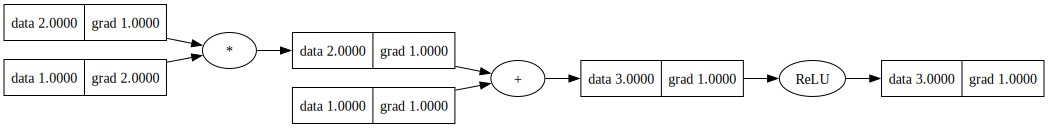

In [4]:
# a very simple example
x = Tensor(1.0)
y = (x * 2 + 1).relu()
y.backprop()
draw_dot(y)

Tensor object with data -4.0 :  [1, 1]

Tensor object with data -2.0 :  [2.0, -2.0]

Tensor object with data 1.0 :  []

Tensor object with data -2.0 :  [2.0, 2.0]

Tensor object with data 2.0 :  []

Tensor object with data -4.0 :  []



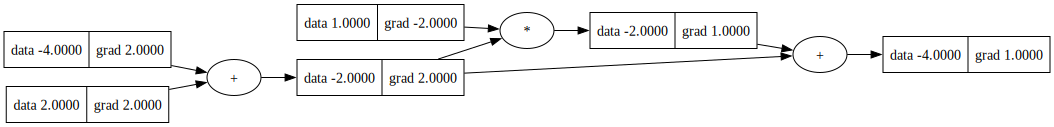

In [5]:
#my own test for incest cases (child and parent making child nodes)
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
c += c * 1

c.backprop()
draw_dot(c)

NEW TOPO SORT (worked cuz it can detect and avoid incest cases):
        nodeList = []
        visitedNodes = set()

        def getNodes(val):
            if val not in visitedNodes:
                for child in val.children:
                    getNodes(child)
                nodeList.append(val)
                visitedNodes.add(val)
        getNodes(self)
        visitedNodes.reverse()

OLD TOPO SORT (didn't work, couldn't identify or avoid incest cases):
        childList = []
        def getChildren(val):
            if val not in childList:
                childList.append(val)
                for child in val.children:
                    getChildren(child)
        getChildren(self)

Tensor object with data -3.0 :  [1, 1]

Tensor object with data 1.0 :  [1, 1]

Tensor object with data 4.0 :  [0.0, -4.0]

Tensor object with data -1.0 :  []

Tensor object with data -3.0 :  [1, 1.0]

Tensor object with data 1.0 :  []

Tensor object with data -4.0 :  []



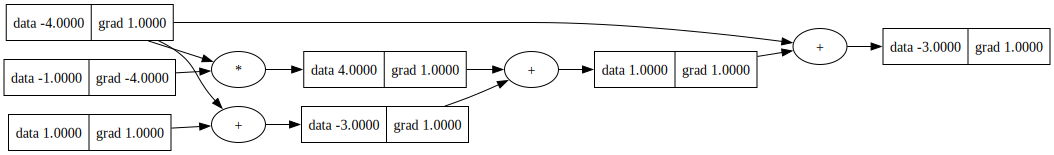

In [6]:
#my own test for correct neg() bookeeping
a = Tensor(-4.0)
b = Tensor(2.0)
c = a
c += 1 + c + (-a)
c.backprop()
draw_dot(c)

Tensor object with data -20.0 :  [1, 1]

Tensor object with data -160.0 :  [-4.0, 40.0]

Tensor object with data 140.0 :  [1, -3.0]

Tensor object with data 40.0 :  [-3.0, -3.0]

Tensor object with data 40.0 :  [12.0, 70.0]

Tensor object with data 0.0 :  [9.0]

Tensor object with data 100.0 :  [1]

Tensor object with data 100.0 :  [-11.0, -11.0]

Tensor object with data -10.0 :  [-11.0, 59.0]

Tensor object with data -6.0 :  [-11.0, -11.0]

Tensor object with data 2.0 :  []

Tensor object with data -8.0 :  [44.0, 37.0]

Tensor object with data -4.0 :  []

Tensor object with data 2.0 :  []



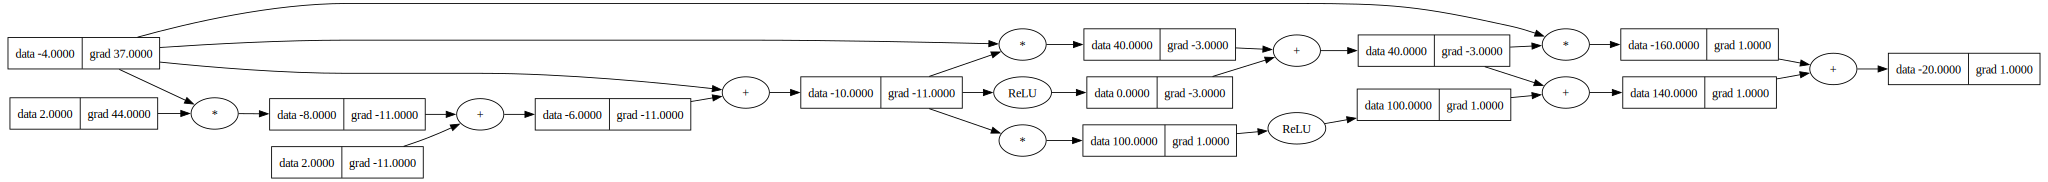

In [7]:
x = Tensor(-4.0)
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backprop()
draw_dot(y)

Tensor object with data 24.70408163265306 :  [1, 1]

Tensor object with data 0.20408163265306123 :  [0.02040816326530612, -0.004164931278633903]

Tensor object with data 10.0 :  []

Tensor object with data 24.5 :  [0.4958350687213661, -12.25]

Tensor object with data 2.0 :  []

Tensor object with data 49.0 :  [-6.941690962099126, nan]

Tensor object with data 2.0 :  []

Tensor object with data -7.0 :  [-6.941690962099126, 6.941690962099126]

Tensor object with data 6.0 :  [6.941690962099126, 6.941690962099126]

Tensor object with data 6.0 :  [6.941690962099126, 6.941690962099126]

Tensor object with data 6.0 :  [6.941690962099126]

Tensor object with data 6.0 :  [6.941690962099126, -6.941690962099126]

Tensor object with data 0.0 :  [0.0, 27.766763848396504]

Tensor object with data 3.0 :  []

Tensor object with data 0.0 :  [27.766763848396504, 27.766763848396504]

Tensor object with data 0.0 :  [27.766763848396504, 27.766763848396504]

Tensor object with data 0.0 :  [27.76676384839650

c:\Users\jyava\Desktop\littlegrad2\littlegrad2\engine.py:60: RuntimeWarning: invalid value encountered in log
  other.grad += (self.data ** other.data) * np.log(self.data) * out.grad


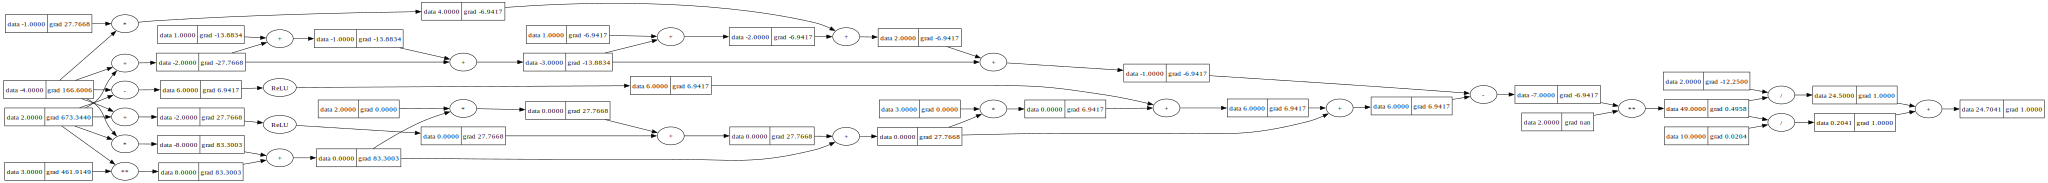

In [8]:
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backprop()
draw_dot(g)

In [9]:
# a simple 2D neuron
import random
from littlegrad import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Tensor(1.0), Tensor(-2.0)]
y = n(x)
y.backprop()

dot = draw_dot(y)
dot

ModuleNotFoundError: No module named 'littlegrad'

In [ ]:
dot.render('gout')

'gout.svg'